# Analysis of CiDiff


## Imports and configuration

In [6]:
import numpy as np
import pandas as pd
import plotnine as pn
import mizani as mi
import mizani.transforms as tr
import statsmodels as sm

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pn.theme_set(pn.theme_minimal())

print("Numpy: %s"%np.__version__)
print("Pandas: %s"%pd.__version__)
print("Plotnine: %s"%pn.__version__)
print("Mizatni: %s"%mi.__version__)
print("statsmodels: %s"%sm.__version__)

Numpy: 1.24.2
Pandas: 1.5.3
Plotnine: 0.10.1
Mizatni: 0.8.1
statsmodels: 0.13.5


In [7]:
DATASET_FILE = "../build/reports/dataset.csv"
BENCHMARK_FILE = "../build/reports/benchmark.csv"
SURVEY_FILE = "../build/reports/survey.csv"

## Dataset Analysis

In [8]:
dataset = pd.read_csv(DATASET_FILE, sep=',')
dataset["total_size"] = dataset["success"] + dataset["failure"]
dataset.head()

,repository,run,language,success,failure,total_size
0,stimulusreflex/cable_ready,run456-0,Ruby,585,603,1188
1,stimulusreflex/cable_ready,run740-0,Ruby,579,498,1077
2,yogeshojha/rengine,run1445-0,JavaScript,62,67,129
3,marcominerva/chatgptnet,run35-0,C#,740,750,1490
4,determinatesystems/nix-installer,run1008-0,Rust,929,550,1479


In [9]:
print(len(dataset))
print(len(set(dataset["repository"].to_list())))
print(len(set(dataset["language"].to_list())))

17906
7955
20


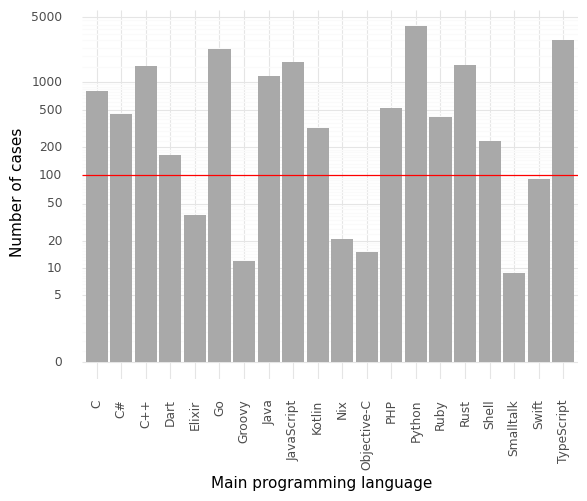

<ggplot: (279867965)>

In [10]:
plot = pn.ggplot(dataset, pn.aes(x="language")) + pn.geom_bar(fill="darkgrey") + pn.theme(axis_text_x = pn.element_text(angle = 90)) + pn.scale_y_continuous(trans=tr.pseudo_log_trans(base=10), breaks=[0, 5, 10, 20, 50, 100, 200, 500, 1000, 5000]) + pn.xlab("Main programming language") + pn.ylab("Number of cases") + pn.geom_hline(yintercept=100, color="red")
plot.save("main_language_per_case.pdf", verbose=False)
plot


In [11]:
dataset["language"].value_counts().to_frame()

,language
Python,3930
TypeScript,2782
Go,2271
JavaScript,1653
Rust,1514
C++,1495
Java,1149
C,807
PHP,528
C#,449


In [12]:
len(set(dataset["repository"].to_list()))

7955

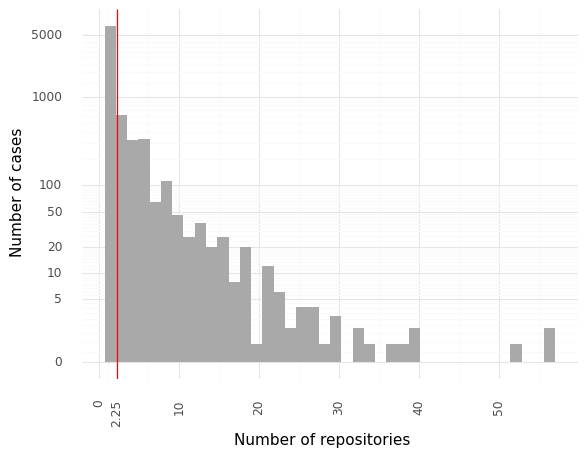

<ggplot: (319439441)>

In [13]:
projects = dataset["repository"].value_counts().to_frame()
plot = pn.ggplot(projects, pn.aes(x="repository")) + pn.geom_histogram(bins=40, fill="darkgrey") + pn.geom_vline(xintercept=projects["repository"].mean(), color="red") + pn.scale_y_continuous(trans=tr.pseudo_log_trans(base=10), breaks=[0, 5, 10, 20,50, 100, 1000, 5000]) + pn.ylab("Number of cases") + pn.scale_x_continuous(breaks=[0, projects["repository"].mean(), 10, 20, 30, 40, 50, 60]) +  pn.xlab("Number of repositories") + pn.theme(axis_text_x = pn.element_text(angle = 90))
plot.save("cases_per_project.pdf", verbose=False)
plot

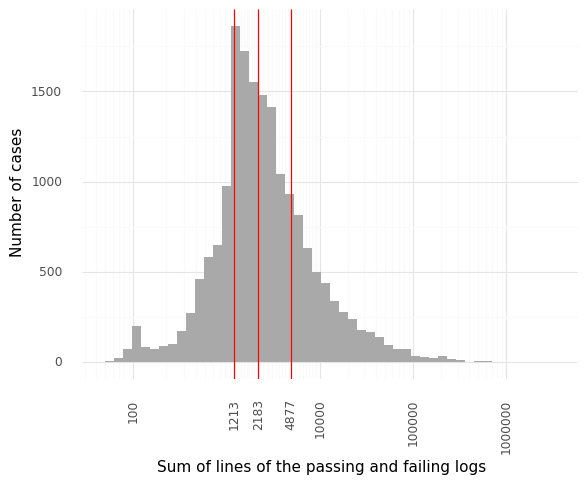

<ggplot: (319326785)>

In [14]:
plot = pn.ggplot(dataset, pn.aes(x="total_size")) + pn.geom_histogram(bins=50, fill="darkgrey") + pn.scale_x_continuous(trans=tr.pseudo_log_trans(base=10), breaks=[0,1,10,100,dataset["total_size"].quantile(0.25),dataset["total_size"].quantile(0.5),dataset["total_size"].quantile(0.75),10000,100000,1000000]) + pn.geom_vline(xintercept=dataset["total_size"].quantile(0.5), color="red") + pn.geom_vline(xintercept=dataset["total_size"].quantile(0.25), color="red") + pn.geom_vline(xintercept=dataset["total_size"].quantile(0.75), color="red") + pn.ylab("Number of cases") + pn.xlab("Sum of lines of the passing and failing logs") + pn.theme(axis_text_x = pn.element_text(angle = 90))
plot.save("total_lines_per_case.pdf", verbose=False)
plot

## Benchmark Results Analysis

In [15]:
data = pd.read_csv(BENCHMARK_FILE, sep=',')
data.head()

,directory,type,duration,lines-left,lines-right,actions,added,deleted,updated,moved-unchanged,moved-updated,similar-groups,similar-groups-left,similar-groups-right
0,stimulusreflex/cable_ready/run456-0,dees-recurse-loggram,4.6,577,588,42,18,7,17,0,0,65,31,34
1,stimulusreflex/cable_ready/run456-0,lcs,1.2,577,588,59,35,24,0,0,0,64,31,33
2,stimulusreflex/cable_ready/run740-0,dees-recurse-loggram,3.4,576,496,107,9,89,9,0,0,48,25,23
3,stimulusreflex/cable_ready/run740-0,lcs,2.7,576,496,116,18,98,0,0,0,48,25,23
4,yogeshojha/rengine/run1445-0,dees-recurse-loggram,0.6,59,64,5,5,0,0,0,0,4,1,3


In [16]:
REFERENCE_TYPE = "lcs"
ALTERNATE_TYPES = ["dees-recurse-loggram"]
REFERENCE_SUFFIX = "_" + REFERENCE_TYPE

In [17]:
data[data["duration"] == -1.0].groupby("type").count()["duration"].to_frame()

,duration
type,
dees-recurse-loggram,76
lcs,76


In [18]:
print(set(data[data["duration"] == -1.0][data["type"] == "lcs"]["directory"].to_list()) - set(data[data["duration"] == -1.0][data["type"] == "dees-recurse-loggram"]["directory"].to_list()))
print(set(data[data["duration"] == -1.0][data["type"] == "dees-recurse-loggram"]["directory"].to_list()) - set(data[data["duration"] == -1.0][data["type"] == "lcs"]["directory"].to_list()))

{'openmod/openmod/run959-0', 'hypfvieh/dbus-java/run132-0'}
{'bforartists/bforartists/run284-0', 'go-skynet/LocalAI/run2902-0'}


/var/folders/kk/cgjmm8nx2cq30pc0gryphmjm0000gn/T/ipykernel_83894/2066432392.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/var/folders/kk/cgjmm8nx2cq30pc0gryphmjm0000gn/T/ipykernel_83894/2066432392.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [19]:
TIMEOUTS = set(data[data["duration"] == -1.0]["directory"].to_list())
data = data[~data["directory"].isin(TIMEOUTS)]

In [20]:
ref_data = data[data["type"] == REFERENCE_TYPE][["directory", "duration", "actions", "added"]]
print(len(ref_data))

variant_data = data[data["type"].isin(ALTERNATE_TYPES)]
merged_data = variant_data.merge(ref_data, left_on="directory", right_on="directory", how="left", suffixes=["", REFERENCE_SUFFIX])

merged_data["duration_diff"] = 100 * (merged_data["duration"] - merged_data["duration" + REFERENCE_SUFFIX]) / (merged_data["duration" + REFERENCE_SUFFIX] + 1)

merged_data["actions_diff"] = 100 * (merged_data["actions"] - merged_data["actions" + REFERENCE_SUFFIX]) / (merged_data["actions" + REFERENCE_SUFFIX] + 1)

merged_data["added_diff"] = 100 * (merged_data["added"] - merged_data["added" + REFERENCE_SUFFIX]) / (merged_data["added" + REFERENCE_SUFFIX] + 1) 

merged_data["total_size"] = merged_data["lines-left"] + merged_data["lines-right"]

merged_data.head()


17828


,directory,type,duration,lines-left,lines-right,actions,added,deleted,updated,moved-unchanged,moved-updated,similar-groups,similar-groups-left,similar-groups-right,duration_lcs,actions_lcs,added_lcs,duration_diff,actions_diff,added_diff,total_size
0,stimulusreflex/cable_ready/run456-0,dees-recurse-loggram,4.6,577,588,42,18,7,17,0,0,65,31,34,1.2,59,35,154.545455,-28.333333,-47.222222,1165
1,stimulusreflex/cable_ready/run740-0,dees-recurse-loggram,3.4,576,496,107,9,89,9,0,0,48,25,23,2.7,116,18,18.918919,-7.692308,-47.368421,1072
2,yogeshojha/rengine/run1445-0,dees-recurse-loggram,0.6,59,64,5,5,0,0,0,0,4,1,3,0.3,5,5,23.076923,0.000000,0.000000,123
3,marcominerva/chatgptnet/run35-0,dees-recurse-loggram,10.6,740,745,602,102,97,403,0,0,134,66,68,8.6,1005,505,20.833333,-40.059642,-79.644269,1485
4,determinatesystems/nix-installer/run1008-0,dees-recurse-loggram,3.5,903,542,403,12,373,16,2,0,62,31,31,2.3,421,30,36.363636,-4.265403,-58.064516,1445


In [21]:
merged_data.groupby("type")[["actions_diff","added_diff", "duration_diff"]].median()

,actions_diff,added_diff,duration_diff
type,,,
dees-recurse-loggram,-20.761756,-60.199128,11.111111


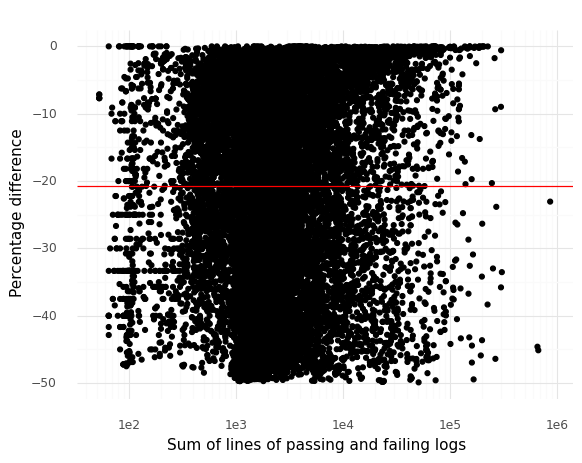

<ggplot: (319436769)>

In [22]:
plot = pn.ggplot(merged_data, pn.aes(x="total_size", y="actions_diff")) + pn.geom_point() + pn.geom_hline(yintercept=merged_data[merged_data["type"].isin(ALTERNATE_TYPES)]["actions_diff"].median(), color="red") + pn.facet_wrap("type", labeller=lambda x: "") + pn.scale_x_log10() + pn.xlab("Sum of lines of passing and failing logs") + pn.ylab("Percentage difference") + pn.theme_minimal()
# plot.save(filename="actions_diff.pdf", verbose=False)
plot

/Users/falleri/.pyenv/versions/3.11.2/lib/python3.11/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/falleri/.pyenv/versions/3.11.2/lib/python3.11/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: actions_diff.pdf


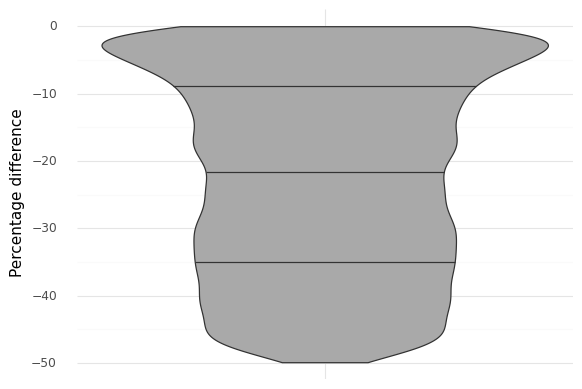

<ggplot: (319897593)>

In [23]:
plot = pn.ggplot(merged_data, pn.aes(x="type", y="actions_diff")) + pn.geom_violin(fill="darkgrey", draw_quantiles=[0.25,0.5,0.75]) + pn.ylab("Percentage difference") + pn.xlab("") + pn.theme(axis_text_x=pn.element_blank())
plot.save(filename="actions_diff.pdf")
plot

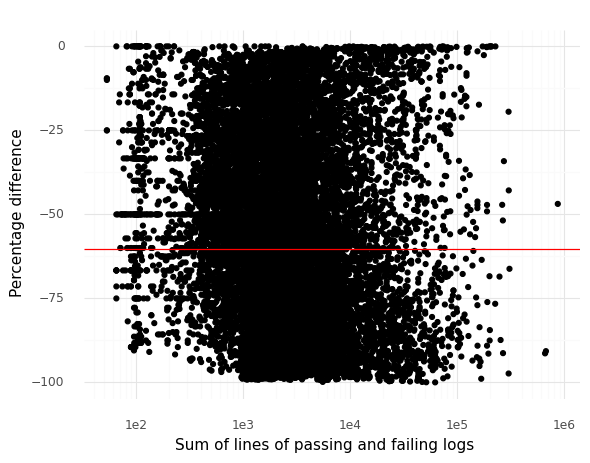

<ggplot: (320064201)>

In [24]:
plot = pn.ggplot(merged_data, pn.aes(x="total_size", y="added_diff")) + pn.geom_point() + pn.geom_hline(yintercept=merged_data[merged_data["type"].isin(ALTERNATE_TYPES)]["added_diff"].median(), color="red") + pn.facet_wrap("type", labeller=lambda x: "") + pn.scale_x_log10() + pn.xlab("Sum of lines of passing and failing logs") + pn.ylab("Percentage difference") + pn.theme_minimal()
# plot.save(filename="added_diff.pdf", verbose=False)
plot

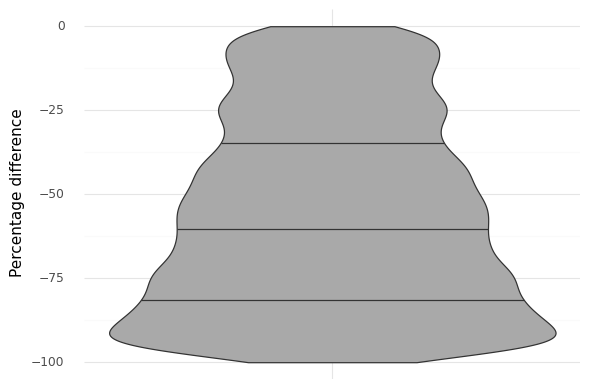

<ggplot: (320433945)>

In [25]:
plot = pn.ggplot(merged_data, pn.aes(x="type", y="added_diff")) + pn.geom_violin(fill="darkgrey", draw_quantiles=[0.25,0.5,0.75]) + pn.ylab("Percentage difference") + pn.xlab("") + pn.theme(axis_text_x=pn.element_blank())
plot.save(filename="added_diff.pdf", verbose=False)
plot

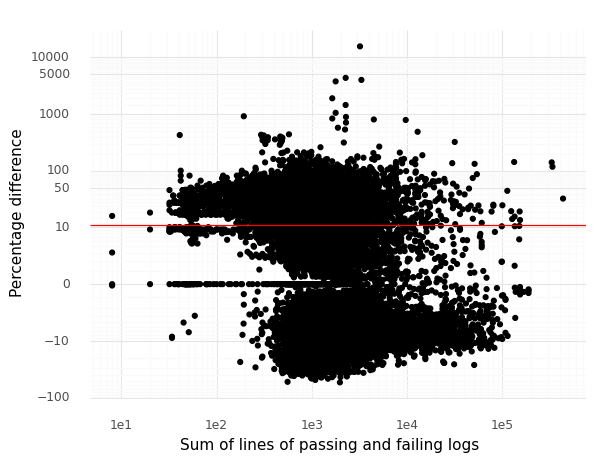

<ggplot: (320453305)>

In [26]:
plot = pn.ggplot(merged_data, pn.aes(x="lines-left", y="duration_diff")) + pn.geom_point() + pn.geom_hline(yintercept=merged_data[merged_data["type"].isin(ALTERNATE_TYPES)]["duration_diff"].median(), color="red") + pn.facet_wrap("type", labeller=lambda x: "") + pn.scale_x_log10() + pn.scale_y_continuous(trans=tr.pseudo_log_trans(base=10), breaks=[-100, -10, 0, 10, 50, 100, 1000, 5000, 10000]) + pn.xlab("Sum of lines of passing and failing logs") + pn.ylab("Percentage difference") + pn.theme_minimal()
# plot.save(filename="runtime_diff.pdf", verbose=False)
plot

/Users/falleri/.pyenv/versions/3.11.2/lib/python3.11/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/falleri/.pyenv/versions/3.11.2/lib/python3.11/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: runtime_diff.pdf


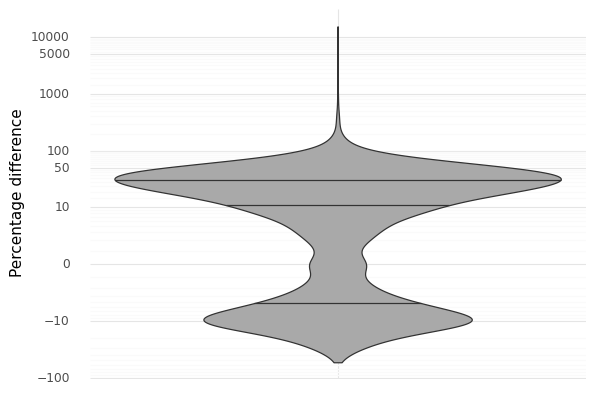

<ggplot: (320265473)>

In [27]:
plot = pn.ggplot(merged_data, pn.aes(x="type", y="duration_diff")) + pn.geom_violin(fill="darkgrey", draw_quantiles=[0.25,0.5,0.75]) + pn.scale_y_continuous(trans=tr.pseudo_log_trans(base=10), breaks=[-100, -10, 0, 10, 50, 100, 1000, 5000, 10000]) + pn.ylab("Percentage difference") + pn.xlab("") + pn.theme(axis_text_x=pn.element_blank())
plot.save(filename="runtime_diff.pdf")
plot

In [28]:
merged_data[merged_data["duration_diff"] > 1000]

,directory,type,duration,lines-left,lines-right,actions,added,deleted,updated,moved-unchanged,moved-updated,similar-groups,similar-groups-left,similar-groups-right,duration_lcs,actions_lcs,added_lcs,duration_diff,actions_diff,added_diff,total_size
11244,utopia-rise/fmod-gdnative/run33-2,dees-recurse-loggram,474.8,2263,2253,1460,165,175,618,16,486,282,147,135,29.9,2580,1285,1439.805825,-43.394033,-87.091757,4516
11245,utopia-rise/fmod-gdnative/run33-4,dees-recurse-loggram,880.3,1777,1568,1392,176,385,462,61,308,958,477,481,21.9,2223,1007,3748.471616,-37.365108,-82.440476,3345
11247,utopia-rise/fmod-gdnative/run33-1,dees-recurse-loggram,1194.1,2264,2173,1400,99,190,430,16,665,257,140,117,26.0,2511,1210,4326.296296,-44.227707,-91.742362,4437
11249,utopia-rise/fmod-gdnative/run33-10,dees-recurse-loggram,388.6,1638,1481,1053,92,249,389,95,228,851,463,388,18.6,1765,804,1887.755102,-40.317101,-88.447205,3119
11250,utopia-rise/fmod-gdnative/run33-5,dees-recurse-loggram,296.2,1777,1593,1478,170,354,684,26,244,809,415,394,24.9,2432,1124,1047.490347,-39.210851,-84.800000,3370
13350,netlify/netlify-cms/run1345-0,dees-recurse-loggram,1515.8,3202,3189,435,11,24,400,0,0,794,398,396,8.7,835,411,15537.113402,-47.846890,-97.087379,6391
15148,rickclephas/kmp-nativecoroutines/run282-0,dees-recurse-loggram,1093.7,3312,3298,1259,228,242,427,347,15,904,455,449,25.8,2048,1017,3984.701493,-38.506589,-77.504912,6610


In [29]:
print(len(merged_data[merged_data["type"].isin(ALTERNATE_TYPES)][merged_data["duration"] > 1000]))
print(len(merged_data[merged_data["type"].isin(ALTERNATE_TYPES)][merged_data["duration"] > 5000]))
print(len(merged_data[merged_data["type"].isin(ALTERNATE_TYPES)][merged_data["duration"] > 10000]))

print(len(merged_data[merged_data["type"].isin(ALTERNATE_TYPES)][merged_data["duration_lcs"] > 1000]))
print(len(merged_data[merged_data["type"].isin(ALTERNATE_TYPES)][merged_data["duration_lcs"] > 5000]))
print(len(merged_data[merged_data["type"].isin(ALTERNATE_TYPES)][merged_data["duration_lcs"] > 10000]))

723
291
151
738
294
161


## Survey Analysis

In [30]:
survey = pd.read_csv(SURVEY_FILE, sep=',')
survey.replace(to_replace={"alpha": "CiDiff", "beta": "LCS-diff", "apha": "CiDiff", "none": "None"}, inplace=True)
survey.head()

,id,side-by-side,summary,p1,p2,p3
0,bytedeco/javacpp-presets/run46-1,diff 0,None,None,None,None
1,netlify/netlify-plugin-nextjs/run4250-0,diff 1,None,None,None,CiDiff
2,python-markdown/markdown/run641-7,diff 2,None,None,None,None
3,ufbx/ufbx/run1143-4,diff 3,CiDiff,CiDiff,None,CiDiff
4,eliaskosunen/scnlib/run307-3,diff 4,None,None,None,None


In [31]:
ratios = pd.DataFrame({"p": survey["summary"].value_counts() / len(survey)}).reset_index()
ratios["p_min"] = np.maximum(ratios["p"] - 0.10, 0)
ratios["p_max"] = np.minimum(ratios["p"] + 0.10, 1)

ratios

,index,p,p_min,p_max
0,CiDiff,0.70,0.60,0.80
1,None,0.25,0.15,0.35
2,LCS-diff,0.05,0.00,0.15


/Users/falleri/.pyenv/versions/3.11.2/lib/python3.11/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/falleri/.pyenv/versions/3.11.2/lib/python3.11/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: survey.pdf


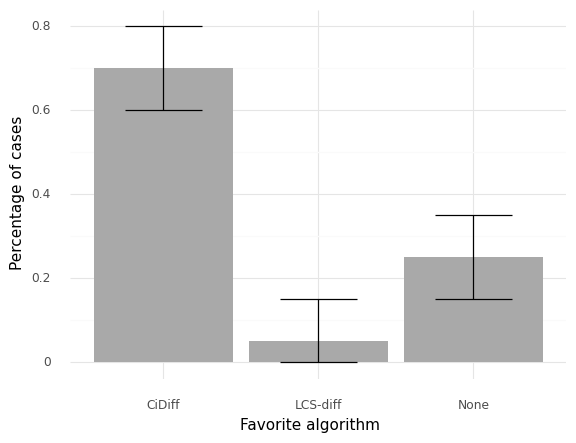

<ggplot: (319389485)>

In [32]:
plot = pn.ggplot(ratios, pn.aes(x="index", y="p")) + pn.geom_bar(stat="identity", fill="darkgrey") + pn.geom_errorbar(pn.aes(ymin="p_min", ymax="p_max")) + pn.ylab("Percentage of cases") + pn.xlab("Favorite algorithm")
plot.save(filename="survey.pdf")
plot

In [33]:
ratings = survey[["p1", "p2", "p3"]]
ratings["none"] = (ratings[["p1", "p2", "p3"]] == "None").sum(axis=1)
ratings["cidiff"] = (ratings[["p1", "p2", "p3"]] == "CiDiff").sum(axis=1)
ratings["lcs"] = (ratings[["p1", "p2", "p3"]] == "LCS-diff").sum(axis=1)

final_ratings = ratings[["none", "cidiff", "lcs"]]

sm.stats.inter_rater.fleiss_kappa(final_ratings, method="fleiss")

/var/folders/kk/cgjmm8nx2cq30pc0gryphmjm0000gn/T/ipykernel_83894/793957973.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/kk/cgjmm8nx2cq30pc0gryphmjm0000gn/T/ipykernel_83894/793957973.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0.24551386623164734

In [34]:
survey[survey["summary"] == "LCS-diff"]

,id,side-by-side,summary,p1,p2,p3
72,kreneskyp/ix/run573-0,diff 72,LCS-diff,CiDiff,LCS-diff,LCS-diff
75,apollographql/apollo-client-nextjs/run24-0,diff 75,LCS-diff,CiDiff,LCS-diff,LCS-diff
82,npm/ini/run266-17,diff 82,LCS-diff,CiDiff,LCS-diff,LCS-diff
84,flathunters/flathunter/run634-0,diff 84,LCS-diff,CiDiff,LCS-diff,LCS-diff
89,mohsenabrishami/stethoscope/run554-0,diff 89,LCS-diff,CiDiff,LCS-diff,LCS-diff
